## Project 9 Part 1 - Airbnb Rent Price Prediction



### Notebook Content

1. Exploratory Data Analysis 
2. Data Preparation




## 1. Exploratory Data Analysis 
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce
from feature_engine.selection import (DropCorrelatedFeatures, SmartCorrelatedSelection DropConstantFeatures) 
from feature_engine.selection import (DropDuplicateFeatures, SmartCorrelatedSelection, RecursiveFeatureAddition)
from feature_engine.outliers import OutlierTrimmer

from datetime import datetime
from dateutil import relativedelta

Load Dataset:

In [85]:
data = pd.read_csv('datasets/train.csv')

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

In [140]:
data.describe()

,id,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,7.411100e+04,74111.000000,74111.000000,73911.000000,74111.000000,74111.000000,74111.000000,57389.000000,74020.000000,73980.000000
mean,1.126662e+07,4.782069,3.155146,1.235263,38.445958,-92.397525,20.900568,94.067365,1.265793,1.710868
std,6.081735e+06,0.717394,2.153589,0.582044,3.080167,21.705322,37.828641,7.836556,0.852143,1.254142
min,3.440000e+02,0.000000,1.000000,0.000000,33.338905,-122.511500,0.000000,20.000000,0.000000,0.000000
25%,6.261964e+06,4.317488,2.000000,1.000000,34.127908,-118.342374,1.000000,92.000000,1.000000,1.000000
50%,1.225415e+07,4.709530,2.000000,1.000000,40.662138,-76.996965,6.000000,96.000000,1.000000,1.000000
75%,1.640226e+07,5.220356,4.000000,1.000000,40.746096,-73.954660,23.000000,100.000000,1.000000,2.000000
max,2.123090e+07,7.600402,16.000000,8.000000,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000


In [11]:
data.head(2)

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0


We'll start making some changes in our variables:

• Select New York city:

In [116]:
data['city'].value_counts()

NYC        32349
LA         22453
SF          6434
DC          5688
Chicago     3719
Boston      3468
Name: city, dtype: int64

In [117]:
data = data[data['city']=='NYC']

In [120]:
data = data.reset_index(drop=True)

- We create price variable:

In [122]:
data['price'] = np.exp(data['log_price'])
data = data.drop(columns='log_price')

- Transform the mixed variables feature 'host_response_rate' into numerical:  



In [123]:
data['host_response_rate_n'] = data['host_response_rate'].str.extract('(\d+)') 
data['host_response_rate_n']=data['host_response_rate_n'].astype('Int64')/100
data[['host_response_rate', 'host_response_rate_n']].head()

,host_response_rate,host_response_rate_n
0,NaN,<NA>
1,100%,1.0
2,100%,1.0
3,100%,1.0
4,71%,0.71


- 9 variables will be deleted: 

    - id
    - name
    - thumbnail_url
    - description 
    - amenities 
    - zipcode 
    - neighbourhood
    - first_review 
    - host_response_rate

In [124]:
data = data.drop(columns=['id', 'name', 'city', 'thumbnail_url', 'description', 'amenities', 'zipcode', 'neighbourhood', 'first_review', 'host_response_rate'])

- Transform cleaning fee from bool into categorical:

In [125]:
data['cleaning_fee'] = data['cleaning_fee'].map({True: 't', False: 'f'})

- Transforming 'last_review' and 'host_since' in useful variables:

In [58]:
today = datetime.strptime('2019-10-30', "%Y-%m-%d") 

Function to transform our datetime data into numerical data representing months difference from today:

In [126]:
def data_into_dif(df, var):                                         
    for i in range(len(df)):
        if not (pd.isnull(df[var][i])):    
            df[var][i]=datetime.strptime(df[var][i], "%Y-%m-%d");        
            df[var][i]=relativedelta.relativedelta(today, df[var][i]);   
            df[var][i]=df[var][i].months + (df[var][i].years * 12);      

In [127]:
data_into_dif(data, 'last_review')
data_into_dif(data, 'host_since')

We must still convert our column data into Int64 dtype which will recognize the null values:

In [128]:
data['last_review']=data['last_review'].astype('Int64')  
data['host_since']=data['host_since'].astype('Int64')

In [129]:
data['host_since'].dtype

Int64Dtype()

Final dataframe:  
- 21 variables:     
   - 11 numerical   
       -> 1 label: price  
       -> 7 continous: 'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating', last_review, host_since, 'host_response_rate'   
       -> 4 numerical discrete: accommodates, bathrooms, bedrooms, beds.  
   
   - 8 categorical: 'property_type','room_type', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable'.

#### Find categorical variables 

In [130]:
categorical = [var for var in data.columns if data[var].dtype=='O']  

print('There are {} categorical variables:'.format(len(categorical)))


There are 8 categorical variables:


['property_type',
 'room_type',
 'bed_type',
 'cancellation_policy',
 'cleaning_fee',
 'host_has_profile_pic',
 'host_identity_verified',
 'instant_bookable']

#### Find numerical variables (target, continuous, discrete)

In [131]:
numerical = [var for var in data.columns if data[var].dtype!='O']
print('There are {} numerical variables:'.format(len(numerical)))
numerical

There are 12 numerical variables:


['accommodates',
 'bathrooms',
 'host_since',
 'last_review',
 'latitude',
 'longitude',
 'number_of_reviews',
 'review_scores_rating',
 'bedrooms',
 'beds',
 'price',
 'host_response_rate_n']

#### Find discrete variables

In [132]:
discrete = []

for var in numerical:
    if len(data[var].unique()) < 20:
        print(var, 'values: ', data[var].unique())
        discrete.append(var)
print()
print('There are {} discrete variables'.format(len(discrete)))

accommodates values:  [ 3  7  5  2  8  6  4  1 12 10 16  9 13 11 15 14]
bathrooms values:  [1.  1.5 nan 2.  3.5 0.5 0.  3.  2.5 4.5 4.  5.  8.  5.5 6. ]
bedrooms values:  [ 1.  3.  2.  0.  4.  5.  7. nan  6. 10.  8.  9.]
beds values:  [ 1.  3.  2.  6.  4.  5. nan  7.  8. 10. 13.  9. 12. 16. 11.  0. 15. 18.]

There are 4 discrete variables


#### Continuous variables

In [133]:
continuous = [var for var in numerical if var not in discrete and var not in ['price']]

print('There are {} numerical and continuous variables'.format(len(continuous)))
continuous

There are 7 numerical and continuous variables


['host_since',
 'last_review',
 'latitude',
 'longitude',
 'number_of_reviews',
 'review_scores_rating',
 'host_response_rate_n']

#### Missing values

In [20]:
for var in data.columns:
    if data[var].isnull().sum() > 0:
        print(var, data[var].isnull().mean())

bathrooms 0.00269865472062177
host_has_profile_pic 0.0025367354373844637
host_identity_verified 0.0025367354373844637
host_since 0.0025367354373844637
last_review 0.21355804131640377
review_scores_rating 0.22563452119118618
bedrooms 0.0012278878978829054
beds 0.0017676188420072594
host_response_rate_n 0.24691341366328884


#### Outliers and distributions

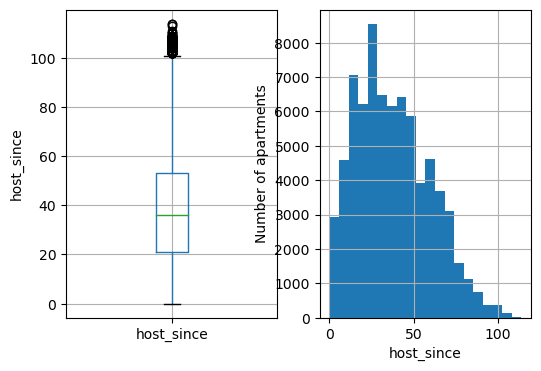

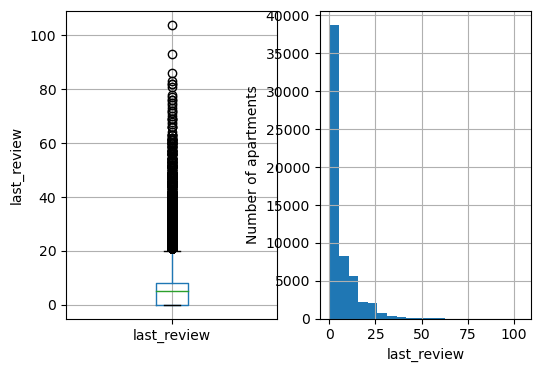

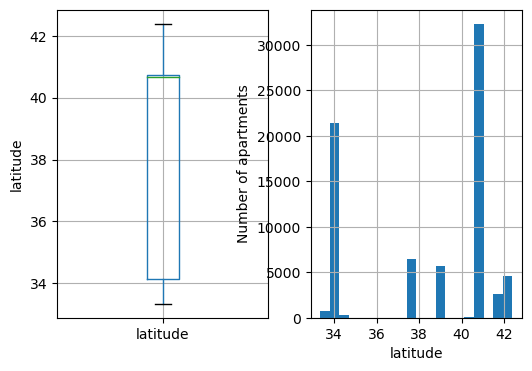

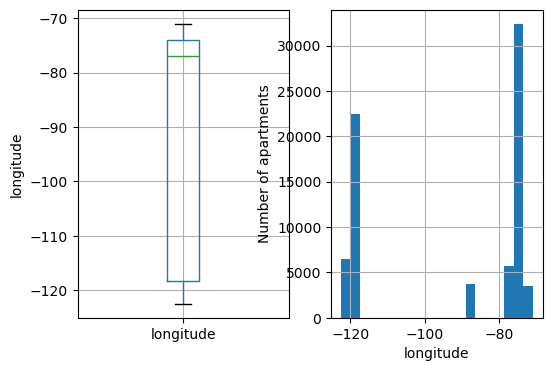

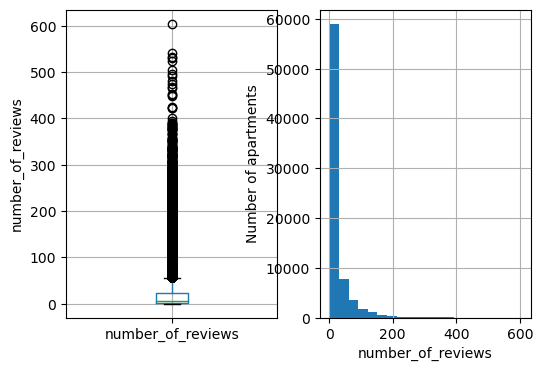

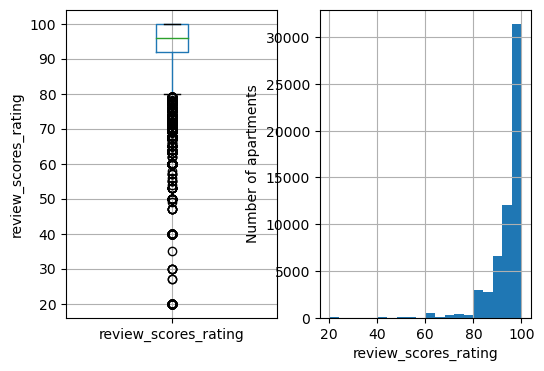

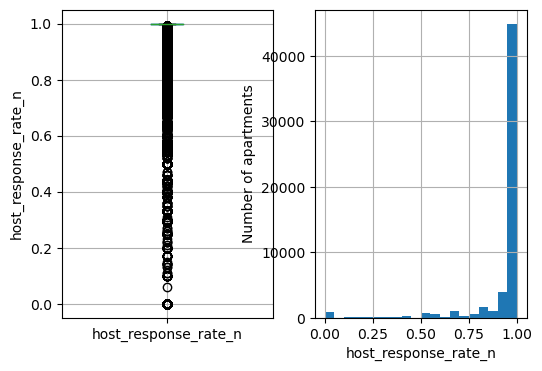

In [40]:
for var in continuous:
    plt.figure(figsize=(6,4))
    plt.subplot(1, 2, 1)
    fig = data.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = data[var].hist(bins=20)
    fig.set_ylabel('Number of apartments')
    fig.set_xlabel(var)

    plt.show()

#### Outliers in discrete variables

We will call outliers those values that are present in less than 5 % of the houses.

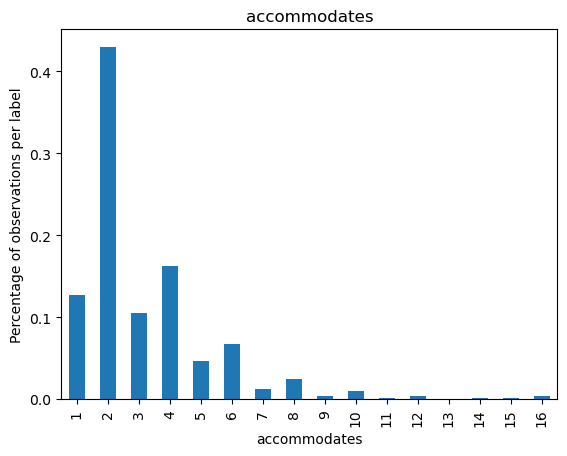

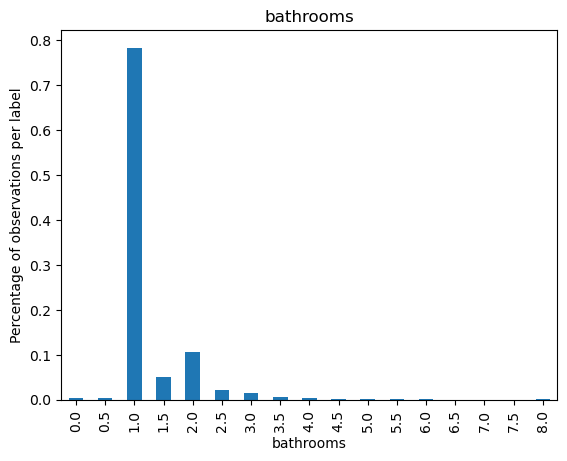

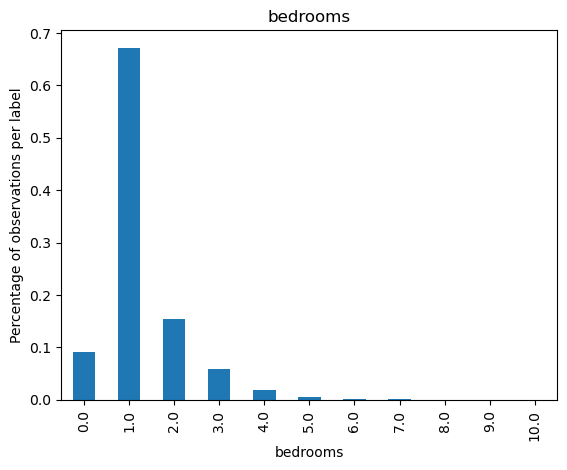

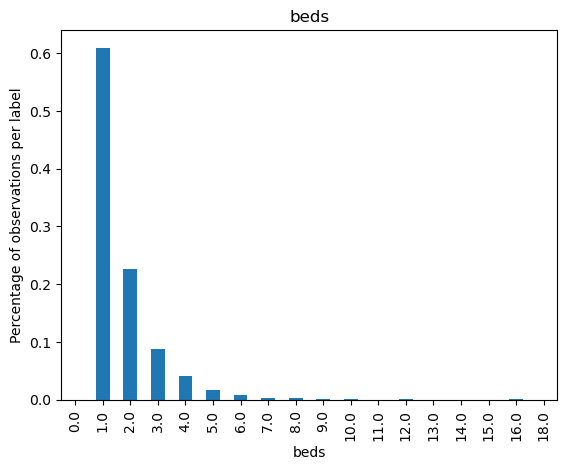

In [41]:
for var in discrete:
    (data.groupby(var)[var].count() / len(data)).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show()

Most of the discrete variables have values  shared by a small proportion of houses.

#### Monotonicity Analysis between discrete variables and target values

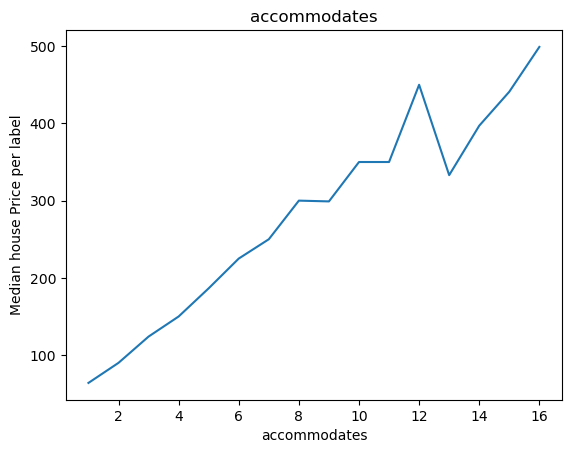

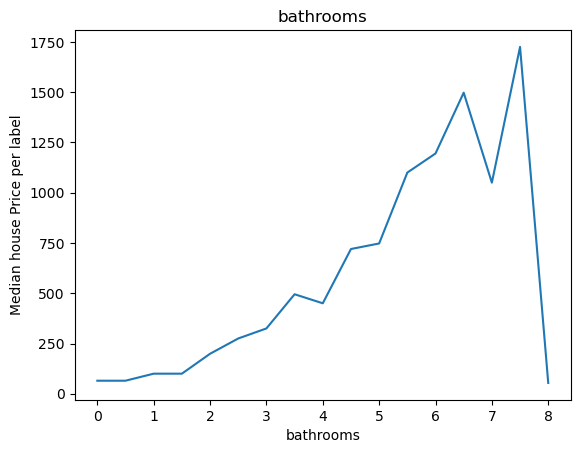

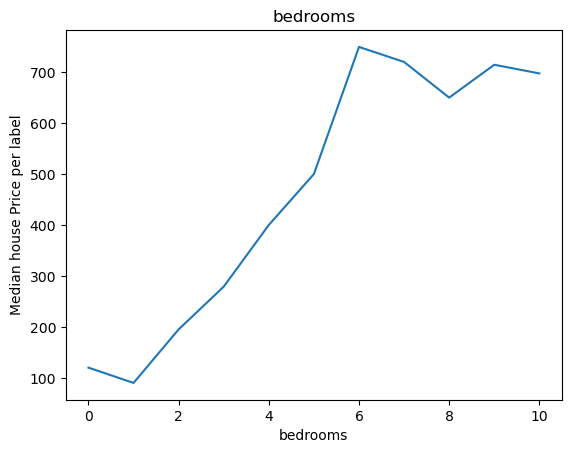

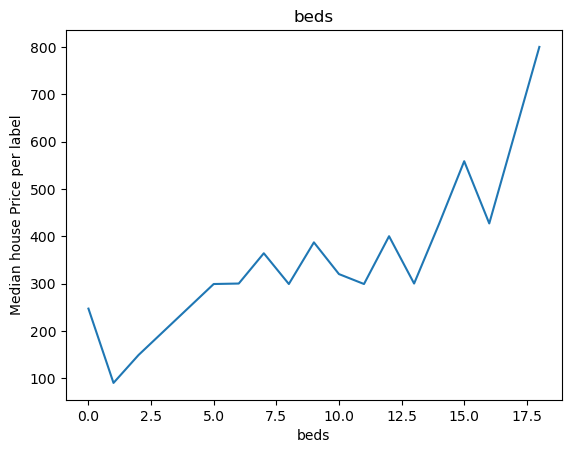

In [132]:
for var in discrete:
    data.groupby(var)['price'].median().plot()
    plt.ylabel('Median house Price per label')
    plt.title(var)
    plt.show()


#### Cardinality

Analizing cardinality of our categorical variables:

Text(0, 0.5, 'Number of different categories')

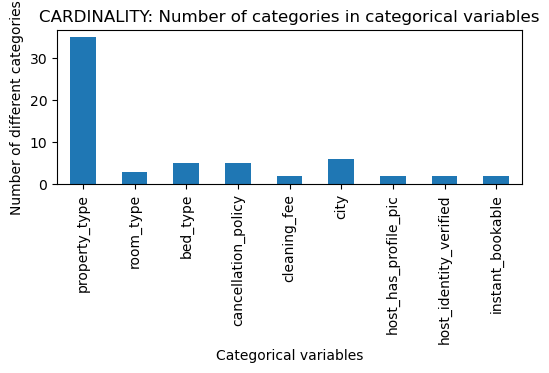

In [23]:
data[categorical].nunique().plot.bar(figsize=(6,2))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

Most of the variables, contain only a few labels but 'property_type' (high cardinality). 

Categories inspection:

In [134]:
pd.set_option('display.max_colwidth', 0)

data[categorical].agg(['unique']).transpose()

,unique
property_type,"[Apartment, House, Loft, Hostel, Condominium, Townhouse, Other, Bed & Breakfast, Timeshare, Serviced apartment, Guesthouse, Bungalow, Boutique hotel, Guest suite, Boat, Villa, Dorm, Vacation home, In-law, Chalet, Yurt, Cabin, Tent, Earth House, Castle]"
room_type,"[Entire home/apt, Private room, Shared room]"
bed_type,"[Real Bed, Futon, Pull-out Sofa, Airbed, Couch]"
cancellation_policy,"[strict, moderate, flexible, super_strict_30, super_strict_60]"
cleaning_fee,"[t, f]"
host_has_profile_pic,"[t, nan, f]"
host_identity_verified,"[t, f, nan]"
instant_bookable,"[f, t]"


Number of categories in 'property_type' should be reduced.

Train test split:

In [135]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['price'], axis=1),
    data['price'],
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((25879, 19), (6470, 19))

## 2. Data Preparation

#### Missing data 

##### Continuous variables

In [24]:
for col in continuous:     
    if X_train[col].isnull().mean() > 0 :
        print(col, X_train[col].isnull().mean())

host_since 0.00271555795439212
last_review 0.21311226555120766
review_scores_rating 0.22534070975576845
host_response_rate_n 0.24686277155579545


##### Discrete variables

In [27]:
for col in discrete:                              
    if X_train[col].isnull().mean() > 0 :
        print(col, X_train[col].isnull().mean())

bathrooms 0.0027324247739846175
bedrooms 0.0011975441910673324
beds 0.001585481041694778


Imputation techniques we will use: additional variable with NA and median imputation.

##### Categorical variables

In [52]:
for col in categorical:
    if X_train[col].isnull().mean() > 0:
        print(col, X_train[col].isnull().mean())

host_has_profile_pic 0.00271555795439212
host_identity_verified 0.00271555795439212


Imputation technique we will use: Add missing label.

#### Pipeline

In [136]:
X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [178]:
house_pipe_1 = Pipeline([

    ('missing_ind', mdi.AddMissingIndicator(
        variables=continuous)),  
    
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='median',
        variables=continuous)), 
    
    ('imputer_cat', mdi.CategoricalImputer(variables=categorical+discrete, return_object=True)), 

    ('rare_label_enc', ce.RareLabelEncoder(
        tol=0.05, n_categories=1, variables=categorical+discrete)),
    
    ('categorical_enc', ce.OrdinalEncoder(                                  
        encoding_method='ordered', variables=categorical+discrete)),       
   
])

In [179]:
house_pipe_1.fit(X_train, y_train)

Pipeline(steps=[('missing_ind',
                 AddMissingIndicator(variables=['host_since', 'last_review',
                                                'latitude', 'longitude',
                                                'number_of_reviews',
                                                'review_scores_rating',
                                                'host_response_rate_n'])),
                ('imputer_num',
                 MeanMedianImputer(variables=['host_since', 'last_review',
                                              'latitude', 'longitude',
                                              'number_of_reviews',
                                              'review_scores_rating',
                                              'host_response_rate_n'])),
                ('impu...
                                             'host_has_profile_pic',
                                             'host_identity_verified',
                                             'instant_bookable', 'accommodates',
                                             'bathrooms', 'bedrooms',
                                             'beds'])),
                ('categorical_enc',
                 OrdinalEncoder(variables=['property_type', 'room_type',
                                           'bed_type', 'cancellation_policy',
                                           'cleaning_fee',
                                           'host_has_profile_pic',
                                           'host_identity_verified',
                                           'instant_bookable', 'accommodates',
                                           'bathrooms', 'bedrooms', 'beds']))])

In [180]:
X_train_ = house_pipe_1.transform(X_train)
X_test_ = house_pipe_1.transform(X_test)

In [181]:
X_train_.head(2)

,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,host_has_profile_pic,host_identity_verified,host_since,...,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,host_response_rate_n,host_since_na,last_review_na,review_scores_rating_na,host_response_rate_n_na
27840,1,1,0,0,1,1,1,0,2,47,...,-73.985237,14,100.0,1,0,1.0,0,0,0,0
20609,1,1,0,0,1,1,0,0,1,73,...,-73.951153,0,96.0,0,0,1.0,0,1,1,0


In [182]:
X_test_.head(2)

,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,host_has_profile_pic,host_identity_verified,host_since,...,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,host_response_rate_n,host_since_na,last_review_na,review_scores_rating_na,host_response_rate_n_na
16553,2,1,0,0,1,1,0,0,2,50,...,-73.981589,1,96.0,0,0,1.0,0,0,1,1
12555,1,2,2,0,1,2,1,0,2,51,...,-73.992054,17,98.0,0,1,0.9,0,0,0,0


#### Ouliers filtering

In [183]:
data['price'].describe()

count    32349.000000
mean     143.024576  
std      130.634639  
min      1.000000    
25%      70.000000   
50%      105.000000  
75%      175.000000  
max      1999.000000 
Name: price, dtype: float64

Reensemble target to be able for outlier filtering:

In [184]:
X_train_['price'] = y_train 
X_test_['price'] = y_test 

In [186]:
def plot_boxplot_and_hist(data, variable):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.50, 0.85)})

    sns.boxplot(x=data[variable], ax=ax_box)
    sns.histplot(data=data, x=variable, ax=ax_hist)

    ax_box.set(xlabel="")
    plt.title(variable)
    plt.show()

In [187]:
trimmer = OutlierTrimmer(variables=["price"],
                         capping_method="iqr",
                         tail="both",
                         fold=1.5,
                         )

In [188]:
trimmer.fit(X_train_)

OutlierTrimmer(capping_method='iqr', fold=1.5, tail='both', variables=['price'])

In [195]:
print(X_train_.shape, X_test_.shape)
print(y_train.shape, y_test.shape)

X_train__ = trimmer.transform(X_train_)
X_test__ = trimmer.transform(X_test_)

print(X_train__.shape, X_test__.shape)
print(X_train__['price'].shape, X_test__['price'].shape) 

(25879, 24) (6470, 24)
(25879,) (6470,)
(24426, 24) (6134, 24)
(24426,) (6134,)


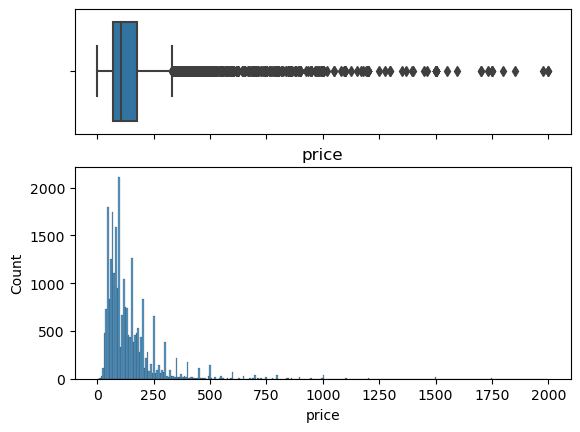

In [196]:
plot_boxplot_and_hist(X_train_, "price") # before trimming

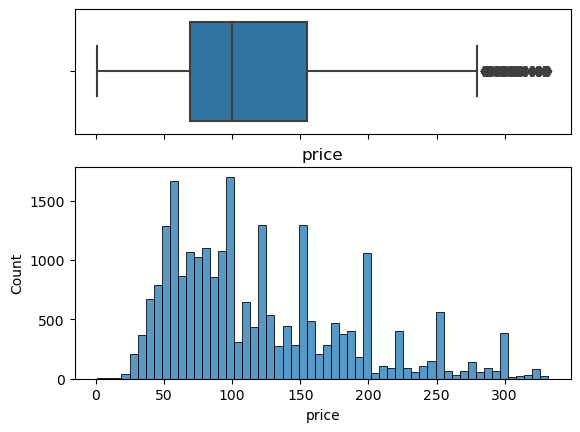

In [197]:
plot_boxplot_and_hist(X_train__, "price") # before trimming

#### Export dataset

Export filtered dataset for part 2:

In [198]:
X_train__.to_csv('E:/0 Projects/Project 9/datasets/ds_train_v2.csv', index=False)
X_test__.to_csv('E:/0 Projects/Project 9/datasets/ds_test_v2.csv', index=False)